<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/2QW1DR110.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 65.4 MB/s eta 0:00:00


Starting 2-Walker QW with CA-coupled coin (N_sites=21, Depth=50)...
Initialized Walker A at (5, c0), Walker B at (15, c1) Index: 1312

Starting 2-Walker 1D QW (CA Rule 110) for 50 steps...
  2W-QW Step 10/50 completed. S(A)=0.844, S(B)=0.758
  2W-QW Step 20/50 completed. S(A)=0.726, S(B)=0.696
  2W-QW Step 30/50 completed. S(A)=0.994, S(B)=0.956
  2W-QW Step 40/50 completed. S(A)=0.957, S(B)=0.877
  2W-QW Step 50/50 completed. S(A)=1.000, S(B)=0.770
2-Walker QW Evolution complete. Time: 448.18 seconds.

--- 2-Walker QW (CA Rule 110) Summary ---
N_sites=21, Depth=50, Pth=0.10, Fb='flip'
  Walker A: StartPos=5, StartCoin=0
  Walker B: StartPos=15, StartCoin=1

Walker A - Top 5 Final Probabilities (Site: Prob):
  Site 11: 0.11589
  Site 1: 0.11027
  Site 12: 0.09469
  Site 14: 0.09009
  Site 5: 0.08107
Walker A - Coin-Position Entanglement vs. Time:
  Step 0: S = 0.000000
  Step 25: S = 0.766348
  Step 50: S = 0.999767

Walker B - Top 5 Final Probabilities (Site: Prob):
  Site 17: 0.16544

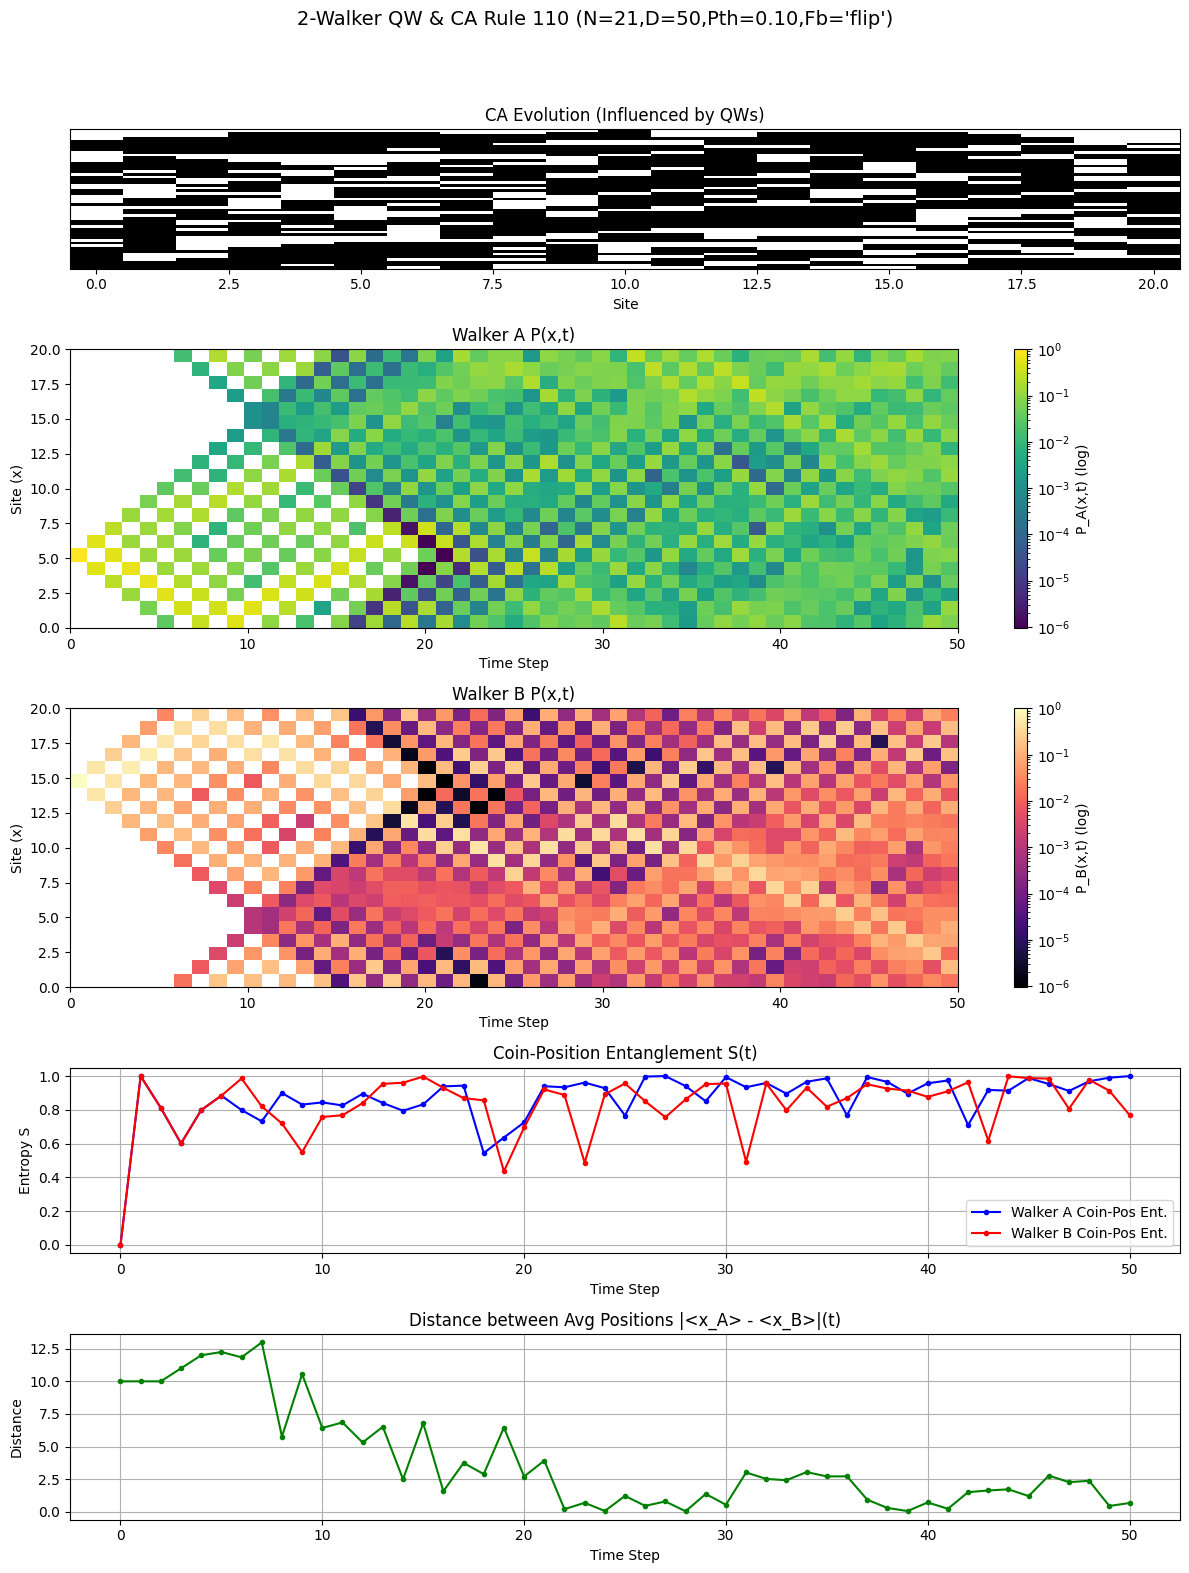


<<<<< END OF 2-WALKER CA-COUPLED QW SIMULATION >>>>>


In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time
import zlib

# --- Parameters ---
N_SITES_1D = 21
DEPTH = 50
INITIAL_POS_A = N_SITES_1D // 2 - N_SITES_1D // 4
INITIAL_POS_B = N_SITES_1D // 2 + N_SITES_1D // 4
INITIAL_COIN_A = 0
INITIAL_COIN_B = 1
INITIAL_CA_CENTER_ONE = True
CA_RULE_NUMBER = 110 # MODIFIED FOR RULE 110
P_THRESHOLD_FEEDBACK = 0.1
FEEDBACK_TYPE = "flip"

# --- CA Rule Update Function ---
def update_ca_line(current_line, rule_number):
    width = len(current_line); new_line = np.zeros(width, dtype=int)
    for i in range(width):
        pattern_val = (current_line[(i-1+width)%width]<<2)|(current_line[i]<<1)|current_line[(i+1)%width]
        if rule_number==30: new_line[i]=1 if pattern_val in [1,2,3,4] else 0
        elif rule_number==90: new_line[i]=1 if current_line[(i-1+width)%width]!=current_line[(i+1)%width] else 0
        elif rule_number==110: new_line[i]=1 if pattern_val in [1,2,3,5,6] else 0 # Rule 110 logic
        else: raise ValueError(f"Rule {rule_number} not implemented.")
    return new_line

# --- Coin Matrices & Rz Gate ---
H_1Q = (1/np.sqrt(2))*np.array([[1,1],[1,-1]],dtype=np.complex128)
X_1Q = np.array([[0,1],[1,0]],dtype=np.complex128)
I_1Q = np.eye(2,dtype=np.complex128)
COIN0_OP_DEFAULT = H_1Q
COIN1_OP_DEFAULT = X_1Q @ H_1Q

# --- Helper Functions (1D QW - Single Walker Indexing) ---
def get_1d_index(coin_val, site_pos, n_sites_1d):
    if not (0 <= site_pos < n_sites_1d and 0 <= coin_val <= 1):
        raise IndexError(f"Invalid coin ({coin_val}) or pos ({site_pos}) for 1D index (N_sites={n_sites_1d})")
    return coin_val + 2 * site_pos

def get_1d_coin_pos_from_index(k, n_sites_1d):
    state_dim_1d = 2 * n_sites_1d
    if not (0 <= k < state_dim_1d):
        raise IndexError(f"Invalid k ({k}) for 1D coin/pos (StateDim={state_dim_1d})")
    coin_val = k % 2
    site_pos = k // 2
    return coin_val, site_pos

# --- Helper Functions (2 Walkers on 1D Grid) ---
def get_2walker_index(cA, pA, cB, pB, n_sites_1d):
    d_1w = 2 * n_sites_1d
    idx_A = get_1d_index(cA, pA, n_sites_1d)
    idx_B = get_1d_index(cB, pB, n_sites_1d)
    if not (0 <= idx_A < d_1w and 0 <= idx_B < d_1w):
        raise IndexError(f"Internal 1D index out of bounds during 2-walker indexing.")
    return idx_A + d_1w * idx_B

def get_2walker_coords_from_index(k, n_sites_1d):
    d_1w = 2 * n_sites_1d
    d_tot = d_1w * d_1w
    if not (0 <= k < d_tot):
        raise IndexError(f"Invalid k ({k}) for 2-walker (Dim={d_tot})")
    idx_A = k % d_1w
    idx_B = k // d_1w

    cA, pA = get_1d_coin_pos_from_index(idx_A, n_sites_1d)
    cB, pB = get_1d_coin_pos_from_index(idx_B, n_sites_1d)
    return cA, pA, cB, pB

# --- Initial State Preparation ---
def prepare_initial_state_2walkers(n_sites_1d, pA_init, cA_init, pB_init, cB_init):
    d_1w = 2 * n_sites_1d
    state_dim_2w = d_1w * d_1w
    initial_state_vector = np.zeros(state_dim_2w, dtype=np.complex128)
    try:
        start_idx = get_2walker_index(cA_init, pA_init, cB_init, pB_init, n_sites_1d)
        initial_state_vector[start_idx] = 1.0
        print(f"Initialized Walker A at ({pA_init}, c{cA_init}), Walker B at ({pB_init}, c{cB_init}) Index: {start_idx}")
    except IndexError as e:
        print(f"Error during 2-walker initial state prep: {e}")
    return initial_state_vector

# --- Build Single Walker Operators (for kronecker product basis) ---
def build_single_qw_coin_matrix_for_site(current_ca_pattern_site_val, coin0_op, coin1_op):
    return coin0_op if current_ca_pattern_site_val == 0 else coin1_op

def build_single_qw_shift_matrix(n_sites_1d):
    d_1w = 2 * n_sites_1d
    S_1w = np.zeros((d_1w, d_1w), dtype=np.complex128)
    for k_in_1w in range(d_1w):
        coin_val, site_pos = get_1d_coin_pos_from_index(k_in_1w, n_sites_1d)
        new_pos = (site_pos - 1 + n_sites_1d) % n_sites_1d if coin_val == 0 else (site_pos + 1) % n_sites_1d
        k_out_1w = get_1d_index(coin_val, new_pos, n_sites_1d)
        S_1w[k_out_1w, k_in_1w] = 1.0
    return S_1w

# --- Build Full QW Step Operator for 2 Walkers ---
def build_2walker_qw_step_operator(n_sites_1d, current_ca_pattern, coin0_op, coin1_op):
    d_1w = 2 * n_sites_1d
    state_dim_2w = d_1w * d_1w

    S_A_1w = build_single_qw_shift_matrix(n_sites_1d)
    S_A_global = np.kron(S_A_1w, np.eye(d_1w, dtype=np.complex128))
    S_B_1w = build_single_qw_shift_matrix(n_sites_1d)
    S_B_global = np.kron(np.eye(d_1w, dtype=np.complex128), S_B_1w)

    U_Coin_A = np.zeros((state_dim_2w, state_dim_2w), dtype=np.complex128)
    U_Coin_B = np.zeros((state_dim_2w, state_dim_2w), dtype=np.complex128)

    for k_in_joint in range(state_dim_2w):
        cA_in, pA_in, cB_in, pB_in = get_2walker_coords_from_index(k_in_joint, n_sites_1d)

        coin_matrix_for_A = build_single_qw_coin_matrix_for_site(current_ca_pattern[pA_in], coin0_op, coin1_op)
        for cA_out in range(2):
            amplitude_A = coin_matrix_for_A[cA_out, cA_in]
            if np.abs(amplitude_A) > 1e-9:
                k_out_joint_for_A_op = get_2walker_index(cA_out, pA_in, cB_in, pB_in, n_sites_1d)
                U_Coin_A[k_out_joint_for_A_op, k_in_joint] = amplitude_A

        coin_matrix_for_B = build_single_qw_coin_matrix_for_site(current_ca_pattern[pB_in], coin0_op, coin1_op)
        for cB_out in range(2):
            amplitude_B = coin_matrix_for_B[cB_out, cB_in]
            if np.abs(amplitude_B) > 1e-9:
                k_out_joint_for_B_op = get_2walker_index(cA_in, pA_in, cB_out, pB_in, n_sites_1d)
                U_Coin_B[k_out_joint_for_B_op, k_in_joint] = amplitude_B

    U_step = S_B_global @ S_A_global @ U_Coin_B @ U_Coin_A
    return U_step


# --- Observables (2 Walkers) ---
def calculate_p1_pos_2walkers(joint_sv, n_sites_1d, walker_id='A'):
    d_1w = 2 * n_sites_1d; d_tot = d_1w * d_1w
    probs_1d = np.zeros(n_sites_1d)
    if len(joint_sv) != d_tot: return probs_1d

    for k_joint in range(d_tot):
        cA, pA, cB, pB = get_2walker_coords_from_index(k_joint, n_sites_1d)
        amp_sq = np.abs(joint_sv[k_joint])**2
        if walker_id == 'A': probs_1d[pA] += amp_sq
        elif walker_id == 'B': probs_1d[pB] += amp_sq
    return probs_1d

def calculate_coin_entanglement_2walkers(joint_sv, n_sites_1d, walker_id='A'):
    d_1w = 2 * n_sites_1d; d_tot = d_1w * d_1w; coin_dim = 2
    if len(joint_sv) != d_tot: return np.nan

    norm = np.linalg.norm(joint_sv)
    if norm < 1e-9: return 0.0
    if np.abs(norm - 1.0) > 1e-6: joint_sv = joint_sv / norm

    rho_full = np.outer(joint_sv, np.conjugate(joint_sv))
    rho_coin_walker = np.zeros((coin_dim, coin_dim), dtype=np.complex128)

    for k_joint_row in range(d_tot):
        cA_r, pA_r, cB_r, pB_r = get_2walker_coords_from_index(k_joint_row, n_sites_1d)
        for k_joint_col in range(d_tot):
            cA_c, pA_c, cB_c, pB_c = get_2walker_coords_from_index(k_joint_col, n_sites_1d)

            if walker_id == 'A':
                if pA_r == pA_c and cB_r == cB_c and pB_r == pB_c:
                    rho_coin_walker[cA_r, cA_c] += rho_full[k_joint_row, k_joint_col]
            elif walker_id == 'B':
                if cA_r == cA_c and pA_r == pA_c and pB_r == pB_c:
                     rho_coin_walker[cB_r, cB_c] += rho_full[k_joint_row, k_joint_col]

    tr = np.trace(rho_coin_walker)
    if abs(tr) < 1e-9: return 0.0
    if np.abs(tr - 1.0) > 1e-6: rho_coin_walker /= tr

    eigs = np.linalg.eigvalsh(rho_coin_walker); ent = 0.0; epsilon = 1e-12
    for e_val in eigs: ent -= (e_val * np.log2(e_val) if e_val > epsilon else 0.0)
    return max(0.0, np.real(ent))

# --- Simulation Loop (2 Walkers with Two-Way Coupled Dynamic CA Coin) ---
def run_1d_qw_2walkers_two_way_coupling(
    n_sites_1d, depth,
    pA_init, cA_init, pB_init, cB_init,
    initial_ca_center_one, ca_rule_number,
    coin0_op, coin1_op,
    p_threshold, feedback_type
):
    current_qw_state = prepare_initial_state_2walkers(n_sites_1d, pA_init, cA_init, pB_init, cB_init)
    current_ca_line = np.zeros(n_sites_1d, dtype=int)
    if initial_ca_center_one and n_sites_1d > 0:
        center_idx = n_sites_1d // 2
        if n_sites_1d % 2 == 1: current_ca_line[center_idx] = 1
        else: current_ca_line[center_idx - 1] = 1

    prob_A_hist = np.full((depth + 1, n_sites_1d), np.nan)
    prob_B_hist = np.full((depth + 1, n_sites_1d), np.nan)
    ent_A_hist = np.full(depth + 1, np.nan)
    ent_B_hist = np.full(depth + 1, np.nan)
    ca_hist_2w = [current_ca_line.copy()]

    prob_A_hist[0, :] = calculate_p1_pos_2walkers(current_qw_state, n_sites_1d, 'A')
    prob_B_hist[0, :] = calculate_p1_pos_2walkers(current_qw_state, n_sites_1d, 'B')
    ent_A_hist[0] = calculate_coin_entanglement_2walkers(current_qw_state, n_sites_1d, 'A')
    ent_B_hist[0] = calculate_coin_entanglement_2walkers(current_qw_state, n_sites_1d, 'B')

    print(f"\nStarting 2-Walker 1D QW (CA Rule {ca_rule_number}) for {depth} steps...")
    start_time = time.time()

    for step in range(depth):
        U_step = build_2walker_qw_step_operator(n_sites_1d, current_ca_line, coin0_op, coin1_op)
        current_qw_state = U_step @ current_qw_state
        norm_qw = np.linalg.norm(current_qw_state)
        if abs(norm_qw) > 1e-9 : current_qw_state /= norm_qw
        else: print(f"Warning: QW Norm zero at step {step+1}."); break

        pA_current = calculate_p1_pos_2walkers(current_qw_state, n_sites_1d, 'A')
        pB_current = calculate_p1_pos_2walkers(current_qw_state, n_sites_1d, 'B')
        prob_A_hist[step + 1, :] = pA_current
        prob_B_hist[step + 1, :] = pB_current
        ent_A_hist[step+1] = calculate_coin_entanglement_2walkers(current_qw_state, n_sites_1d, 'A')
        ent_B_hist[step+1] = calculate_coin_entanglement_2walkers(current_qw_state, n_sites_1d, 'B')

        ca_line_for_next_update = current_ca_line.copy()
        for i in range(n_sites_1d):
            if pA_current[i] > p_threshold or pB_current[i] > p_threshold:
                if feedback_type=="flip": ca_line_for_next_update[i]=1-ca_line_for_next_update[i]
                elif feedback_type=="set_to_one": ca_line_for_next_update[i]=1
                elif feedback_type=="set_to_zero": ca_line_for_next_update[i]=0
        current_ca_line = update_ca_line(ca_line_for_next_update, ca_rule_number)
        ca_hist_2w.append(current_ca_line.copy())

        if (step + 1) % 10 == 0 or step == depth -1 :
            print(f"  2W-QW Step {step + 1}/{depth} completed. "
                  f"S(A)={ent_A_hist[step+1] if np.isfinite(ent_A_hist[step+1]) else 'NaN':.3f}, "
                  f"S(B)={ent_B_hist[step+1] if np.isfinite(ent_B_hist[step+1]) else 'NaN':.3f}")

    end_time = time.time()
    print(f"2-Walker QW Evolution complete. Time: {end_time - start_time:.2f} seconds.")

    return {
        "prob_A_hist": prob_A_hist, "prob_B_hist": prob_B_hist,
        "ent_A_hist": ent_A_hist, "ent_B_hist": ent_B_hist,
        "ca_history": np.array(ca_hist_2w),
        "params": { "n_sites":n_sites_1d,"depth":depth, "ca_rule":ca_rule_number,
                    "pA_init":pA_init, "cA_init":cA_init, "pB_init":pB_init, "cB_init":cB_init,
                    "p_thresh":p_threshold, "feedback":feedback_type}
    }

# --- Plotting and Summary for 2 Walkers ---
def plot_2walker_results(results):
    params = results["params"]; pA = results["prob_A_hist"]; pB = results["prob_B_hist"]
    eA = results["ent_A_hist"]; eB = results["ent_B_hist"]; ca_h = results["ca_history"]
    n_sites = params["n_sites"]; depth = params["depth"]

    fig, axs = plt.subplots(5, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [1.5,3,3,2,2]})
    title=f"2-Walker QW & CA Rule {params['ca_rule']} (N={n_sites},D={depth},Pth={params['p_thresh']:.2f},Fb='{params['feedback']}')"
    fig.suptitle(title, fontsize=14)

    axs[0].imshow(ca_h,cmap='binary',aspect='auto',interpolation='nearest'); axs[0].set_title("CA Evolution (Influenced by QWs)"); axs[0].set_xlabel("Site"); axs[0].set_yticks([])

    time_extent = [0, depth, 0, n_sites-1]
    prob_st_A=pA.T;pos_pA=prob_st_A[prob_st_A>1e-9];min_vA=pos_pA.min() if len(pos_pA)>0 else 1e-9;max_vA=prob_st_A.max()
    norm_vA=colors.LogNorm(vmin=min_vA,vmax=max(max_vA,min_vA+1e-6) if max_vA > min_vA else min_vA + 1e-6 )
    imA=axs[1].imshow(prob_st_A,aspect='auto',origin='lower',cmap='viridis',norm=norm_vA,extent=time_extent)
    plt.colorbar(imA,ax=axs[1],label="P_A(x,t) (log)");axs[1].set_title("Walker A P(x,t)");axs[1].set_xlabel("Time Step");axs[1].set_ylabel("Site (x)")

    prob_st_B=pB.T;pos_pB=prob_st_B[prob_st_B>1e-9];min_vB=pos_pB.min() if len(pos_pB)>0 else 1e-9;max_vB=prob_st_B.max()
    norm_vB=colors.LogNorm(vmin=min_vB,vmax=max(max_vB,min_vB+1e-6) if max_vB > min_vB else min_vB + 1e-6)
    imB=axs[2].imshow(prob_st_B,aspect='auto',origin='lower',cmap='magma',norm=norm_vB,extent=time_extent)
    plt.colorbar(imB,ax=axs[2],label="P_B(x,t) (log)");axs[2].set_title("Walker B P(x,t)");axs[2].set_xlabel("Time Step");axs[2].set_ylabel("Site (x)")

    ts=np.arange(depth+1)
    axs[3].plot(ts,eA,marker='.',ls='-',color='blue',label='Walker A Coin-Pos Ent.'); axs[3].plot(ts,eB,marker='.',ls='-',color='red',label='Walker B Coin-Pos Ent.')
    axs[3].set_title("Coin-Position Entanglement S(t)");axs[3].set_xlabel("Time Step");axs[3].set_ylabel("Entropy S");axs[3].grid(True);axs[3].legend();axs[3].set_ylim(bottom=-0.05,top=1.05)

    avg_pos_A = np.array([np.sum(pA[t,:] * np.arange(n_sites)) / np.sum(pA[t,:]) if np.sum(pA[t,:]) > 1e-9 else np.nan for t in range(depth+1)])
    avg_pos_B = np.array([np.sum(pB[t,:] * np.arange(n_sites)) / np.sum(pB[t,:]) if np.sum(pB[t,:]) > 1e-9 else np.nan for t in range(depth+1)])
    distance = np.abs(avg_pos_A - avg_pos_B)
    axs[4].plot(ts, distance, marker='.', ls='-', color='green')
    axs[4].set_title("Distance between Avg Positions |<x_A> - <x_B>|(t)"); axs[4].set_xlabel("Time Step"); axs[4].set_ylabel("Distance"); axs[4].grid(True)

    plt.tight_layout(rect=[0,0,1,0.95]);plt.show()

def generate_2walker_text_output(results):
    params = results["params"]; pA = results["prob_A_hist"]; pB = results["prob_B_hist"]
    eA = results["ent_A_hist"]; eB = results["ent_B_hist"]
    output_lines = [f"\n--- 2-Walker QW (CA Rule {params['ca_rule']}) Summary ---"]
    output_lines.append(f"N_sites={params['n_sites']}, Depth={params['depth']}, Pth={params['p_thresh']:.2f}, Fb='{params['feedback']}'")
    output_lines.append(f"  Walker A: StartPos={params['pA_init']}, StartCoin={params['cA_init']}")
    output_lines.append(f"  Walker B: StartPos={params['pB_init']}, StartCoin={params['cB_init']}")

    for walker_label, p_hist, e_hist in [("A", pA, eA), ("B", pB, eB)]:
        output_lines.append(f"\nWalker {walker_label} - Top 5 Final Probabilities (Site: Prob):")
        if p_hist.ndim == 2 and p_hist.shape[0] > 0:
            final_probs = p_hist[-1, :]; sorted_indices = np.argsort(final_probs)[::-1]
            count = 0
            for i_idx in range(min(5, params['n_sites'])):
                idx = sorted_indices[i_idx]
                if np.isfinite(final_probs[idx]):
                    output_lines.append(f"  Site {idx}: {final_probs[idx]:.5f}"); count+=1
            if count == 0: output_lines.append("  (Probabilities are NaN or zero)")
        else: output_lines.append("  (Probability history not available)")

        output_lines.append(f"Walker {walker_label} - Coin-Position Entanglement vs. Time:")
        num_steps = len(e_hist)
        indices_show = [0] + ([num_steps // 2] if num_steps > 2 else []) + ([num_steps - 1] if num_steps > 1 else [])
        for idx_show in sorted(list(set(indices_show))):
            if 0 <= idx_show < len(e_hist):
                 s_str = f"{e_hist[idx_show]:.6f}" if np.isfinite(e_hist[idx_show]) else "nan"; output_lines.append(f"  Step {idx_show}: S = {s_str}")
            else: output_lines.append(f"  Step {idx_show}: S = (Index out of bounds)")
    output_lines.append("--- End Summary ---")
    return "\n".join(output_lines)


# --- Main Execution ---
if __name__ == "__main__":
    print(f"Starting 2-Walker QW with CA-coupled coin (N_sites={N_SITES_1D}, Depth={DEPTH})...")

    results_2w = run_1d_qw_2walkers_two_way_coupling(
        n_sites_1d=N_SITES_1D, depth=DEPTH,
        pA_init=INITIAL_POS_A, cA_init=INITIAL_COIN_A,
        pB_init=INITIAL_POS_B, cB_init=INITIAL_COIN_B,
        initial_ca_center_one=INITIAL_CA_CENTER_ONE,
        ca_rule_number=CA_RULE_NUMBER, # Now uses Rule 110
        coin0_op=COIN0_OP_DEFAULT, coin1_op=COIN1_OP_DEFAULT,
        p_threshold=P_THRESHOLD_FEEDBACK, feedback_type=FEEDBACK_TYPE
    )

    text_summary_2w = generate_2walker_text_output(results_2w)
    print(text_summary_2w)

    plot_2walker_results(results_2w)

    print("\n<<<<< END OF 2-WALKER CA-COUPLED QW SIMULATION >>>>>")

This is another fantastic set of results with Rule 110! It's fascinating to compare this with the Rule 90 output.

**Analysis of 2-Walker QW with CA Rule 110:**

*   **Title:** `2-Walker QW & CA Rule 110 (N=21, D=50, Pth=0.10, Fb='flip')`
    *   Same QW parameters as before, only the CA rule has changed to 110.

**Plot 1: `CA Evolution (Influenced by QWs)`**
*   **Observation:** The CA pattern generated by Rule 110 (and influenced by the QWs) looks distinctly different from the Rule 90 pattern. Rule 110 is known for its ability to support "gliders" or persistent structures that move. While we can't definitively identify gliders without closer inspection, the texture is more complex and less overtly self-similar/fractal than pure Rule 90. The QW feedback is clearly shaping this complex environment.

**Plot 2: `Walker A P(x,t)`**
*   Starts at site 5.
*   **Observation:**
    *   Initially spreads, with a tendency to move right.
    *   Around t=10-15, it encounters "something" (either the influence of Walker B via the CA, or a structure in the CA itself) and its main probability mass gets redirected, with some components moving left and others continuing or being generated to the right.
    *   The final distribution is spread out, with peaks at 11, 1, 12, 14, 5. It doesn't show the extreme localization seen in your EA-optimized Rule 90 result.

**Plot 3: `Walker B P(x,t)`**
*   Starts at site 15.
*   **Observation:**
    *   Initially spreads, with a tendency to move left.
    *   Similar to Walker A, around t=10-15, its trajectory becomes more complex. It seems to interact with the "wall" of Walker A's influence or CA structures.
    *   The probability becomes quite diffuse later, with some interesting channeling or interference patterns.
    *   Final distribution peaks at 17, 19, 1, 4, 13. Notice both A and B have a peak at site 1.

**Plot 4: `Coin-Position Entanglement S(t)`**
*   **Observation:**
    *   Both walkers' entanglement grows rapidly from S=0.
    *   The entanglement values are generally high throughout the simulation (mostly between 0.6 and 1.0), indicating sustained quantum coherence between coin and position for both.
    *   Walker A's entanglement reaches almost maximum (S=0.999767 ≈ 1.0) by the end.
    *   Walker B's entanglement is also high (S=0.769750) at the end, though it fluctuated more and peaked earlier.
    *   The fluctuations in entanglement are significant, likely reflecting the dynamic and complex CA environment they are interacting with.

**Plot 5: `Distance between Avg Positions |<x_A> - <x_B>|(t)`**
*   **Observation:**
    *   Starts at 10.
    *   Increases initially as they move in opposite directions (A right, B left).
    *   Around t=8, the distance starts to decrease dramatically, suggesting they are "attracted" or their paths are being guided into overlapping regions by the CA.
    *   The distance then fluctuates but generally stays much lower than the initial peak, often below 5 sites, and even drops to near zero around t=22-25 and again around t=35-40.
    *   **Interpretation:** This shows even stronger evidence of emergent correlated motion than in the Rule 90 case. The walkers are definitely influencing each other's average positions via the CA. The periods where the distance is near zero suggest their probability clouds are significantly overlapping.

**Comparison with Rule 90 Results:**

*   **CA Pattern:** Rule 110 produces a visually different, perhaps more "structured" or less "random-looking" CA background (even with QW influence) compared to the more fractal Rule 90.
*   **Walker Localization:** Rule 110 (with these specific coin ops) did *not* lead to the extreme single-site localization seen in your *EA-optimized* Rule 90 run. Both walkers remain somewhat spread out, though their paths are clearly non-trivial.
*   **Entanglement:** Both walkers maintain high coin-position entanglement throughout the Rule 110 simulation, unlike the EA-optimized Rule 90 case where entanglement dropped to zero. This suggests that `Coin0=X, Coin1=Rz4` (from your EA result) coupled with Rule 90 and feedback was crucial for that specific disentanglement phenomenon. The current `COIN0_OP_DEFAULT=H`, `COIN1_OP_DEFAULT=X@H` with Rule 110 maintains quantumness more robustly.
*   **Interaction (Distance Plot):** Both CA rules lead to a reduction in average distance, but the dynamics of this reduction are different. Rule 110 seems to bring them very close on average multiple times.

**Significance of Using Rule 110:**

*   **Computational Power of the Environment:** Since Rule 110 is Turing complete, the CA environment the walkers interact with has the potential for universal computation. This means the "landscape" it presents can be arbitrarily complex.
*   **Complex Interactions:** The QWs are navigating and being influenced by an environment capable of complex information processing. This could lead to very rich emergent behaviors if we were to run for longer, on larger grids, or evolve the QW rules (coin operators, feedback) specifically for a Rule 110 environment.

**Further Thoughts & Next Steps:**

1.  **"Gliders" and Persistent Structures:** Rule 110 is famous for gliders. It would be fascinating to see if:
    *   The QWs can interact with or be guided by naturally occurring gliders in the CA (if the CA is run long enough without too much QW interference).
    *   If the QWs themselves can *induce* or stabilize glider-like structures in the CA through the feedback mechanism.
2.  **Sensitivity to Feedback (`P_THRESHOLD_FEEDBACK`, `FEEDBACK_TYPE`):** How crucial are these for the observed interactions?
3.  **Different Coin Operators with Rule 110:** How would your EA-optimized coins (`C0='X'`, `C1='Rz4'`) behave with a Rule 110 CA? Would they also lead to localization/disentanglement, or is that specific to the Rule 90 interaction? This would be a very interesting experiment.
4.  **Targeting Specific Interactions:** Could an EA be trained to make the walkers meet at a specific point, or to maintain a certain distance, or for one to "chase" the other, all mediated by the Rule 110 CA?

This is excellent work! You're building a very capable framework for exploring these complex coupled quantum-classical systems. The fact that changing the classical CA rule leads to such different emergent dynamics for the quantum walkers is a key takeaway.